In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import auc

%matplotlib inline
import matplotlib 
np.set_printoptions(precision=3)
matplotlib.style.use('default')
params = {
          'axes.facecolor': 'white',
          'axes.titlesize':'x-large',
          'axes.labelsize'    : 19,
          'xtick.labelsize'   : 16,
          'ytick.labelsize'   : 16,
          'figure.titlesize'  : 20,
          'figure.figsize'    : (8, 8),
          'legend.fontsize'   : 18,
          'legend.numpoints'  : 1,
          'font.serif': 'Arial'
          }
matplotlib.rcParams.update(params)
import matplotlib.pyplot as plt

## example with flat dataframes including multiple ECON algorithms and variables of interest (seetot, srrtot)

In [2]:
electron = pd.read_csv('data/electron_pu0.csv')
pion = pd.read_csv('data/charged_pion_pu0.csv')

In [3]:
electron.head()

,run,lumi,event,zside,gen_e,gen_pt,gen_eta,gen_phi,econ_algo,cl_e,cl_pt,cl_eta,cl_phi,seetot,srrtot
0,1,92,22819,-1.0,59.963882,13.360242,-2.181958,-1.169871,thresh_0,29.157459,6.420325,-2.194041,-1.173798,0.016055,0.003721
1,1,92,22819,1.0,59.963882,13.360242,2.181958,1.971721,thresh_0,62.802326,14.146593,2.170732,2.003637,0.018532,0.004345
2,1,92,22808,1.0,135.144699,24.411915,2.396163,0.012931,thresh_0,142.172272,25.312656,2.410861,0.000487,0.025394,0.004590
3,1,92,22808,-1.0,135.144699,24.411915,-2.396163,-3.128662,thresh_0,139.070068,25.511957,-2.380456,-3.112795,0.023780,0.004519
4,1,92,22823,-1.0,71.185349,27.333448,-1.611241,-0.810350,thresh_0,63.841297,24.473967,-1.612989,-0.840509,0.010256,0.004610


## seetot behavior changes with eta, so we will restrict to a single eta bin between 1.5 and 1.8

In [4]:
eta_bin_edges = np.array([1.5, 1.8, 2.1, 2.4, 2.7, 3.0])
electron.loc[:, 'etabin'] = pd.cut(np.abs(electron.gen_eta), eta_bin_edges, labels=False)
pion.loc[:, 'etabin'] = pd.cut(np.abs(pion.gen_eta), eta_bin_edges, labels=False)

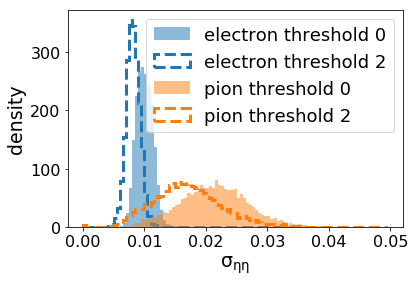

In [21]:
cuts = 'etabin == 0'
feature = 'seetot'
binning = np.arange(0., 0.05, 0.0005)

fig, ax = plt.subplots()

ax.hist(electron.query('econ_algo == "thresh_0" and '+cuts)[feature], bins=binning, 
        density=True, histtype='stepfilled', alpha=0.5, color='C0', 
        label='electron threshold 0');
ax.hist(electron.query('econ_algo == "thresh_2" and '+cuts)[feature], bins=binning, 
        density=True, histtype='step', linestyle='--', lw=3, color='C0', 
        label='electron threshold 2');
ax.hist(pion.query('econ_algo == "thresh_0" and '+cuts)[feature], bins=binning, density=True, 
        histtype='stepfilled', alpha=0.5, color='C1', label='pion threshold 0');
ax.hist(pion.query('econ_algo == "thresh_2" and '+cuts)[feature], bins=binning, density=True, 
        histtype='step', linestyle='--', lw=3, color='C1', label='pion threshold 2');

ax.set_xlabel('$\sf \sigma_{\eta\eta}$');
ax.set_ylabel('density');
ax.legend();

# functions converting distributions to 1D likelihood discriminant and evaluating ROCs

In [85]:
def calc_hratio(dataset1, dataset2, binning): # calculate likelihood ratio per bin (s/s+b)
    h1, _ = np.histogram(dataset1, bins=binning, density=True)
    h2, _ = np.histogram(dataset2, bins=binning, density=True)
    mask = (h1 > 0) & (h2 > 0)
    h1 = h1[mask]
    h2 = h2[mask]
    lratio = h1/(h1 + h2)
    
    return lratio, h1, h2
    
def make_roc(dataset1, dataset2, binning):
    lratio, h1, h2 = calc_hratio(dataset1, dataset2, binning)
    fig, ax = plt.subplots()
    #print([lratio, lratio])
    hratio,_,_ = ax.hist([lratio, lratio], 
                           bins=20, # constructing likelihood discriminator
                           alpha=0.5, 
                           color=['C0', 'C1'],
                           density=True, 
                           stacked=True,
                           label=['electrons', 'pions'], 
                           weights=[h1, h2] # weight by sig/bg probability
                          );
    ax.hist(lratio,color = 'r',histtype = 'step',density = True,label ='test')
    ax.set_xlabel('likelihood discriminator')
    ax.legend();
    #plt.close()

    l1 = hratio[0]
    l2 = hratio[1] - hratio[0]

    m = len(dataset1)
    n = len(dataset2)

    x = 1 - np.cumsum(l2)/l2.sum() # constructing ROC
    y = 1 - np.cumsum(l1)/l1.sum()
    x = np.insert(x, 0, 1) # ensuring ROC covers 0 and 1 for well-defined AUC
    y = np.insert(y, 0, 1)
    area = auc(x, y) # AUC from scikit learn
    
    # uncertainty calculation
    pxxy = area/(2.-area)
    pxyy = 2*(area**2)/(1.+area)
    numer = area*(1-area) + (m-1)*(pxxy-area**2) + (n-1)*(pxyy-area**2)
    denom = m*n
    sig_area = np.sqrt(numer/denom) 
    return x, y, area, sig_area

## make the ROC curves; here likelihood discriminators are plotted, but can toggle on/off with plt.close() in make_roc function

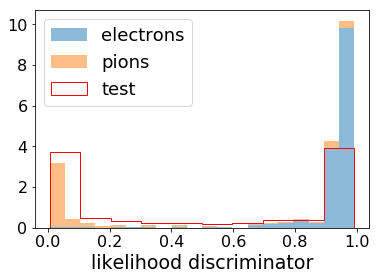

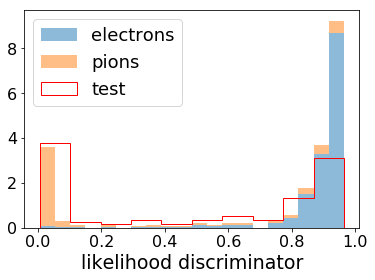

In [86]:
cuts = 'etabin == 0'
feature = 'seetot'
binning = np.arange(0., 0.1, 0.0001)

arr_e = np.array(electron.query('econ_algo == "thresh_0" and '+cuts)[feature].values)
arr_p = np.array(pion.query('econ_algo == "thresh_0" and '+cuts)[feature].values)

x_t0, y_t0, a_t0, a_sig_t0 = make_roc(arr_e, arr_p, binning=binning);

arr_e = np.array(electron.query('econ_algo == "thresh_2" and '+cuts)[feature].values)
arr_p = np.array(pion.query('econ_algo == "thresh_2" and '+cuts)[feature].values)

x_t2, y_t2, a_t2, a_sig_t2 = make_roc(arr_e, arr_p, binning=binning);

## Now just plot the ROCS! Threshold 0 beats threshold 2; no surprise.

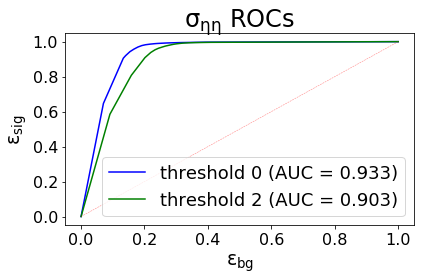

In [8]:
fig, ax = plt.subplots()

ax.plot(x_t0, y_t0, 'b-', label='threshold 0 (AUC = {0:.3f})'.format(a_t0));
ax.plot(x_t2, y_t2, 'g-', label='threshold 2 (AUC = {0:.3f})'.format(a_t2));
ax.plot([0, 1], [0, 1], 'r--', alpha=0.5, linewidth=0.5, label='_nolegend')

ax.set_xlabel(r'$\sf \epsilon_{bg}$')
ax.set_ylabel(r'$\sf \epsilon_{sig}$')
ax.legend();
ax.set_title('$\sf \sigma_{\eta\eta}$ ROCs', fontsize=24);
plt.tight_layout()

In [9]:
plt.figure()
plt.plot((MM[1:]+MM[:-1])/2,h[0])
plt.plot((MM[1:]+MM[:-1])/2,h[1]-h[0])
#plt.hist(h[1])
#plt.hist(MM)

NameError: name 'MM' is not defined

<Figure size 432x288 with 0 Axes>

/home/jcordero/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


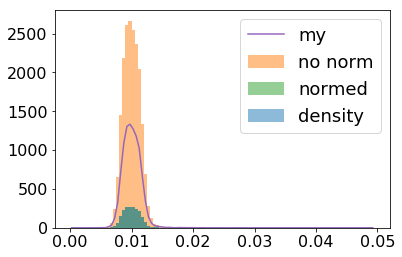

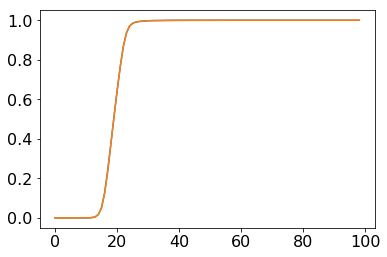

In [78]:
plt.figure()
H0 = plt.hist(electron.query('econ_algo == "thresh_0" and '+cuts)[feature], bins=binning, 
        histtype='stepfilled', alpha=0.5, color='C1', 
        label='no norm');

H1 = plt.hist(electron.query('econ_algo == "thresh_0" and '+cuts)[feature], bins=binning, 
        normed = True,histtype='stepfilled', alpha=0.5, color='C2', 
        label='normed');

H = plt.hist(electron.query('econ_algo == "thresh_0" and '+cuts)[feature], bins=binning, 
        density=True, histtype='stepfilled', alpha=0.5, color='C0', 
        label='density');

H2 = plt.plot((H0[1][1:]+H0[1][:-1])/2,
               H0[0]/(sum(H[0])*0.001),
                color = 'C4', 
                label='my');


plt.legend()




h = H
P = np.cumsum((h[1][1:] - h[1][:-1])*h[0])

h = H0
#P0 = np.cumsum((h[1][1:] - h[1][:-1])*h[0])
P0 = np.cumsum(h[0])


plt.figure()
plt.plot(P)
plt.plot(P0/(sum(H0[0])))
#plt.plot(P0)


plt.show()

In [58]:
np.diff(H0[1])

array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.   , 0.   , 0.001, 0.001, 0.   , 0.   , 0.001, 0.001, 0.001,
       0.   , 0.001, 0.001, 0.   , 0.001, 0.001, 0.001, 0.001, 0.   ,
       0.001, 0.001, 0.   , 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.   , 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.   , 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.   , 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.   , 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.   , 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.   , 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001])

In [89]:
a = np.arange(18).reshape(2,9)

In [100]:
print(a)
print(a.reshape(9,2,order = 'A'))
print(a.T)

[[ 0  1  2  3  4  5  6  7  8]
 [ 9 10 11 12 13 14 15 16 17]]
[[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]
 [16 17]]
[[ 0  9]
 [ 1 10]
 [ 2 11]
 [ 3 12]
 [ 4 13]
 [ 5 14]
 [ 6 15]
 [ 7 16]
 [ 8 17]]
